In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

tf.test.gpu_device_name()


'/device:GPU:0'

# **SPLIT DATASET** 

- pour avoir les datasets train & test 

In [ ]:

import pandas as pn
import numpy as np
from sklearn.model_selection import train_test_split
#parameters
num_neg = 1
import pandas as pn
import numpy as np
from sklearn.model_selection import train_test_split
#parameters
num_neg = 4

def dataset_split(dataset, train_neg, test_neg): #normal testset

    ratings = dataset.reset_index().pivot(index ='user_id', columns = 'item_id', values = 'rating')
    ratings.fillna(0, inplace=True)
    ratings=np.matrix(ratings)

    num_users, num_items = np.shape(ratings)
    
    #POSITIVES
        #test    
    testpos=[]
    indexes = dataset[dataset.user_id==-1].index
    for u in range(num_users):
        i = np.random.randint(num_items)
        while(ratings[u,i]==0):
            i = np.random.randint(num_items)
        testpos.append([[u,i,1]])
        indexes = indexes.append(dataset[(dataset.user_id==u) & (dataset.item_id==i)].index)
    testpos = np.vstack(testpos)
    test=pn.DataFrame(data=testpos,columns=['user_id','item_id','rating'])

        #train
    dataset.drop(indexes , inplace=True)
    trainset = dataset
    
    #NEGATIVES
        #test
    testneg = []

    for u in range(num_users):
        for num_neg in range(test_neg):
            
            i = np.random.randint(num_items)
            while(ratings[u,i]>0):
                i = np.random.randint(num_items)
            ratings[u,i]=1            
            testneg.append([[u,i,0]])
    testneg = pn.DataFrame(data=np.vstack(testneg),columns=['user_id','item_id','rating'])

    test = test.append(testneg)
    test = test.sample(frac=1).reset_index(drop=True)

        #train
    trainneg=[]

    for x in range(trainset.shape[0]):
        for num_neg in range(train_neg):
            
            i = np.random.randint(num_items)
            u = np.random.randint(num_users)
            while(ratings[u,i]>0):
                i = np.random.randint(num_items)
            ratings[u,i]=1            
            trainneg.append([[u,i,0]])
    
    if(trainneg):        
        trainneg = pn.DataFrame(data=np.vstack(trainneg),columns=['user_id','item_id','rating'])
        trainset = trainset.append(trainneg)
    trainset = trainset.sample(frac=1).reset_index(drop=True)
    return trainset, test



users = pn.read_csv('/content/drive/MyDrive/Apres sorting ids/users_AVecEnc.csv', sep='|')
    

items = pn.read_csv('/content/drive/MyDrive/Apres sorting ids/items_AvecEnc.csv', sep='|')

ratings = pn.read_csv('/content/drive/MyDrive/Apres sorting ids/ratings_avecEnc.csv', sep='|')

ratings  = ratings.drop_duplicates(['user_id','item_id'])

reviews=pn.read_csv('/content/drive/MyDrive/Apres sorting ids/Apres sorting ids reviews sentiment/Reviews_sentiment_cleaned_final.csv', delimiter='|')

trainset,test = dataset_split(ratings,num_neg,99)

trainset = pn.merge(trainset,reviews, left_on=['user_id','item_id'], right_on=['user_id','item_id'], how='left')
trainset = pn.merge(trainset,users, left_on='user_id', right_on='user_id', how='left')
trainset = pn.merge(trainset,items, left_on='item_id', right_on='item_id', how='left')

test = pn.merge(test,reviews, left_on=['user_id','item_id'], right_on=['user_id','item_id'], how='left')
test = pn.merge(test,users, left_on='user_id', right_on='user_id', how='left')
test = pn.merge(test,items, left_on='item_id', right_on='item_id', how='left')

trainset.fillna({'fans' : 0,'average_stars': 0,'friends': 0,'vote_funny': 0,'useful': 0,'vote_cool': 0,'hot': 0,'more': 0,'profile': 0,'cute': 0,'list': 0,'note': 0, 'plain': 0,
 'cool': 0,'funny': 0,'writer': 0,'photos': 0},inplace=True)

test.fillna({'fans' : 0,'average_stars': 0,'friends': 0,'vote_funny': 0,'useful': 0,'vote_cool': 0,'hot': 0,'more': 0,'profile': 0,'cute': 0,'list': 0,'note': 0, 'plain': 0,
 'cool': 0,'funny': 0,'writer': 0,'photos': 0},inplace=True)
#trainset.to_csv('/content/drive/MyDrive/Train and Test DataSets/NEG %d/Train.csv'%(num_neg), sep='|', index=False,header = True)
#test.to_csv('/content/drive/MyDrive/Train and Test DataSets/NEG %d/Test.csv'%(num_neg), sep='|', index=False,header = True)

num_users = int(max(test.user_id.max()+1,trainset.user_id.max()+1))
num_items = int(max(test.item_id.max()+1,trainset.item_id.max()+1))


In [ ]:
trainset.columns[trainset.isna().any()].tolist()

['text', 'sentiment']

# **Word embedding for CNN**

In [ ]:
import pandas as pd
import tensorflow as tf
import keras
import re
from tqdm import tqdm
import nltk

from nltk.tokenize import word_tokenize
nltk.download('punkt')

from nltk.corpus import stopwords
nltk.download('stopwords')
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

import numpy as np
from sklearn.model_selection import train_test_split

from gensim.models import KeyedVectors

from keras.layers import Embedding

import gensim
from gensim.models import Word2Vec
import os
Reviews_sentiment_word2vec=pd.read_csv('/content/drive/MyDrive/Apres sorting ids/Apres sorting ids reviews sentiment/Reviews_sentiment_cleaned_final.csv', delimiter='|')
def word_embedding(Reviews_sentiment_word2vec):

    #obtenir a partir du df les features et targets à donner au cnn
    MAX_NB_WORDS=1000
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    texts=Reviews_sentiment_word2vec['text'] #mettre tous les avis dans texts

    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts) #remplacer les mots par leurs index (on obtient pour chaque avis une succession de nombre)
    word_index = tokenizer.word_index #dictionnaire de données qui contient tous les mots de nos avis avec pour chacun une valeur correcpondante a son index (l'operration d'indexage et de création du dictionnaire a été effectuée lors de l'appel à la fonction fit_on_texts)

    MAX_SEQUENCE_LENGTH=3738
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) #les données que le cnn devra interpreter (features)
    labels =Reviews_sentiment_word2vec['sentiment'] #recuperer le sentiment de chaque avis et le mettre dans labels (targets)


    #stoquer les informations (les mots avec leurs vecteur d'embedding correspondant) contenu dans le fichier txt dans un dictionnaire de données nommé embeddings_index
    embeddings_index = {}

    f = open('/content/drive/MyDrive/random files/model_Word2Vec_pretrained.txt','r')

    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()


    #recuperer les vecteur d'embedding de tous les mots des avis a analyser et les mettre dans une matrice nommée embedding_matrix. Il est a noter que si un mot n'est pas trouver son vecteur sera à 0.
    EMBEDDING_DIM=300
    embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
    for word, i in word_index.items():
        embedding_vector = embeddings_index.get(word) #chercher dans le dictionnaire de donnée embeddings_index le vecteur d'emebedding de chaque 
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    return word_index,EMBEDDING_DIM,embedding_matrix,MAX_SEQUENCE_LENGTH

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
def load_CNN_Data(Reviews_sentiment_word2vec):
        #obtenir a partir du df les features et targets à donner au cnn
    MAX_NB_WORDS=1000
    tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
    texts=trainset['text'].dropna() #mettre tous les avis dans texts

    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts) #remplacer les mots par leurs index (on obtient pour chaque avis une succession de nombre)
    word_index = tokenizer.word_index #dictionnaire de données qui contient tous les mots de nos avis avec pour chacun une valeur correcpondante a son index (l'operration d'indexage et de création du dictionnaire a été effectuée lors de l'appel à la fonction fit_on_texts)

    MAX_SEQUENCE_LENGTH=3738
    data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH) #les données que le cnn devra interpreter (features)
    labels =trainset['sentiment'].dropna() #recuperer le sentiment de chaque avis et le mettre dans labels (targets)
    return data,labels

In [ ]:
word_index,EMBEDDING_DIM,embedding_matrix,MAX_SEQUENCE_LENGTH = word_embedding(Reviews_sentiment_word2vec)

In [ ]:
#word_index (chaque mot devant son index)
#EMBEDDING_DIM (ici 300)
#embedding_matrix (array fig les mots et leur poids)
#MAX_SEQUENCE_LENGTH (3738 ici )

# **GENERATE NEW USERS AND ITEMS**
- New users avec comme nom Train2 and Test2

In [ ]:
import pandas as pn
import numpy as np
from sklearn.model_selection import train_test_split

def dataset_split(dataset,train_neg,test_neg):

    ratings = dataset.pivot(index = 'user_id', columns = 'item_id', values = 'rating')
    ratings.fillna(0, inplace=True)
    ratings=np.matrix(ratings)

    num_users, num_items = np.shape(ratings)
    
    users = dataset.user_id.unique()
    items = dataset.item_id.unique()
    '''
    items_per_users = dataset.groupby(['user_id']).size().nsmallest(1208)
    test_users = list(items_per_users.index)
    train_users = list(set(users) - set(test_users))
    '''    
    test_users = []
    train_users = users
    for x in range(int(0.2*num_users)):
        i = np.random.randint(len(train_users))
        test_users.append(train_users[i])
        train_users = np.delete(train_users,i)
        
    
    users = dataset.user_id.unique()
    
    #POSITIVES
        #test    
    testpos=[]
    indexes = dataset[dataset.user_id==-1].index
    for u in test_users:
        
        i = np.random.randint(num_items)
        while(ratings[u,i]==0):
            i = np.random.randint(num_items)
        testpos.append([[u,i,1]])
        indexes = indexes.append(dataset[(dataset.user_id==u) | (dataset.item_id==i)].index)
    
    
    testpos = np.vstack(testpos)
    test=pn.DataFrame(data=testpos,columns=['user_id','item_id','rating'])
    
    
    
    #NEGATIVES
        #test
    test_items = list(test.item_id.unique())      
        
    testneg = []
    for u in test_users:
        for num_neg in range(test_neg):
            for i in test_items:
                if(ratings[u,i]==0):
                    break
                    
            if(ratings[u,i]>0):
                while(ratings[u,i]>0):
                    i = np.random.randint(num_items)
                test_items.append(i)
                indexes = indexes.append(dataset[dataset.item_id==i].index)
            ratings[u,i]=1
            testneg.append([[u,i,0]])
            
    testneg = pn.DataFrame(data=np.vstack(testneg),columns=['user_id','item_id','rating'])
    test = test.append(testneg)
    test = test.sample(frac=1).reset_index(drop=True)
    
    print('test done')
    
        #train
    dataset.drop(indexes , inplace=True)
    train = dataset
    
    test_items = test.item_id.unique()   
    train_items = list(set(items) - set(test_items))
    
    num_train_items = len(train_items)
    num_train_users = len(train_users)
    trainneg=[]

    for x in range(train.shape[0]*train_neg):
        
        i = train_items[np.random.randint(num_train_items)]
        u = train_users[np.random.randint(num_train_users)]
        while(ratings[u,i]>0):
            i = train_items[np.random.randint(num_train_items)]
            u = train_users[np.random.randint(num_train_users)]
        ratings[u,i]=1       
        trainneg.append([[u,i,0]])
    
    trainneg = pn.DataFrame(data=np.vstack(trainneg),columns=['user_id','item_id','rating'])
    train = train.append(trainneg)
    train = train.sample(frac=1).reset_index(drop=True)
    
    
    tests = list(test.item_id.unique())
    trains = list(train.item_id.unique())
    
    for i in tests:
        if(i in trains):
            print('ERROR')
        
    print(num_users,num_items)
    print('nbr users train:',len(train.user_id.unique()))
    print('nbr users test:',len(test.user_id.unique()))
    print('nbr items train:',len(train.item_id.unique()))
    print('nbr items test:',len(test.item_id.unique()))
    return train,test



users = pn.read_csv('/content/drive/MyDrive/Apres sorting ids/users_AVecEnc.csv', sep='|')
    

items = pn.read_csv('/content/drive/MyDrive/Apres sorting ids/items_AvecEnc.csv', sep='|')

ratings = pn.read_csv('/content/drive/MyDrive/Apres sorting ids/ratings_avecEnc.csv', sep='|')

ratings  = ratings.drop_duplicates(['user_id','item_id'])



num_neg = 1

trainset,test = dataset_split(ratings,num_neg,99)


trainset = pn.merge(trainset,users, left_on='user_id', right_on='user_id', how='left')
trainset = pn.merge(trainset,items, left_on='item_id', right_on='item_id', how='left')

test = pn.merge(test,users, left_on='user_id', right_on='user_id', how='left')
test = pn.merge(test,items, left_on='item_id', right_on='item_id', how='left')

trainset.fillna(0,inplace=True)
test.fillna(0,inplace=True)
trainset.to_csv('/content/drive/MyDrive/Train and Test DataSets/NEG %d/Train2.csv'%(num_neg), sep='|', index=False,header = True)
test.to_csv('/content/drive/MyDrive/Train and Test DataSets/NEG %d/Test2.csv'%(num_neg), sep='|', index=False,header = True)



KeyboardInterrupt: ignored

# **Approche Kerboua-Zeghoud** 

In [ ]:
import pandas as pn
import numpy as np
import math
from keras.layers.core import Flatten
from keras.layers import Embedding, Multiply, Dense, Input
from keras.models import Model
from keras.layers.merge import concatenate
from keras.models import load_model
from time import time
import pickle


def save_obj(obj,path):
    with open(path+'.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#Load data from the path saved previously in splitting data set (drive/Neg %d )
#return the data frame and the numbers of user (or items ) to use them in embeddings 
def load_data(path):
    trainset = pn.read_csv(path+'Train.csv', sep='|')
    testset = pn.read_csv(path+'Test.csv', sep='|')
    
    num_users = int(max(testset.user_id.max()+1,trainset.user_id.max()+1))
    num_items = int(max(testset.item_id.max()+1,trainset.item_id.max()+1))
    
    return trainset, testset, num_users, num_items

# Evaluating model with test data set, model name and the model itself. k: number of lines of the dataframe (hea(k))
def evaluate_model(model, model_name, test, k):
    
    #Yelp
    test_userID = test['user_id']
    test_userDATA = test[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
    'profile','cute','list','note','plain', 'cool','funny','writer','photos']] 

    test_itemID = test['item_id']
    test_itemDATA = test.iloc[:,-49:]

    if(model_name in ['GMF','NCF','ColMLP','pretrained NCF']):
        predictions = model.predict([test_userID, test_itemID], verbose=2)
    else:
        predictions = model.predict([test_userID, test_userDATA, test_itemID, test_itemDATA], verbose=2)
        
    predictions = pn.DataFrame(data=predictions,columns=['predicted'])
    predictions = pn.concat([test,predictions], axis=1)
    predictions = predictions.sort_values(by=['predicted'], ascending=False)
    
    users=test.user_id.unique()
    
    hrs, ndcgs = 0,0

    for u in users:
       
        p= predictions[predictions['user_id']==u].loc[:,'rating'].head(k)
        hr, ndcg = evaluate_by_user(p)
        hrs = hrs + hr
        ndcgs = ndcgs + ndcg
        
    mean_hr = hrs/len(users)
    mean_ndcg = ndcgs/len(users)
        
    return mean_hr, mean_ndcg
  #######################################
def evaluate_by_user(test):
    hr, ndcg = 0, 0
    i=1
   
    for rating in test:
        if rating == 1 :
            hr = 1
            ndcg = math.log(2)/math.log(i+1)
            break 
        i=i+1    
    return hr, ndcg
  ########################################
#create model (with embedding sizes of hmlp and gmf and predective factors (test data and number of layers))
#hybrid model (with data)
def build_NHF_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    #Yelp
    input_userDATA = Input(shape = [17], name = 'user_data') 
    input_itemDATA = Input(shape = [49], name = 'item_data')
    #GMF part
    user_latent_factors_GMF = emb_size_gmf
    item_latent_factors_GMF = emb_size_gmf

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])

    #HybMLP part
    user_latent_factors_hMLP = emb_size_hmlp
    item_latent_factors_hMLP = emb_size_hmlp

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)

    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
    

    #NeuHybMF part
    concat_NeuhMF = concatenate([mul_layer,layer])
    
    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhMF)

    model = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], out)
    
    return model



#create GMF model
def build_GMF_model(emb_size):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    user_latent_factors_GMF = emb_size
    item_latent_factors_GMF = emb_size

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])
    
    out = Dense(1, activation='sigmoid', name='output')(mul_layer)

    GMF_model = Model([input_userID, input_itemID], out)

    return GMF_model

#create HybMLP model
def build_hMLP_model(emb_size, predictive_factors, num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    input_userDATA = Input(shape = [17], name = 'user_data') 
    input_itemDATA = Input(shape = [49], name = 'item_data')
    
    user_latent_factors_hMLP = emb_size
    item_latent_factors_hMLP = emb_size

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)
    
    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
        
    out = Dense(1, activation='sigmoid', name='output')(layer)

    hMLP_model = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], out)

    return hMLP_model

#Model without hybridation (user ids only)
def build_NCF_model(emb_size_mlp, emb_size_gmf, predictive_factors, num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    #GMF part
    user_latent_factors_GMF = emb_size_gmf
    item_latent_factors_GMF = emb_size_gmf

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])

    #MLP part
    user_latent_factors_MLP = emb_size_mlp
    item_latent_factors_MLP = emb_size_mlp

    user_emb_MLP = Embedding(num_users, user_latent_factors_MLP, name= 'user_emb_MLP')(input_userID)
    item_emb_MLP = Embedding(num_items, item_latent_factors_MLP, name= 'item_emb_MLP')(input_itemID)

    flat_u_MLP = Flatten()(user_emb_MLP)
    flat_i_MLP = Flatten()(item_emb_MLP)

    concat_MLP = concatenate([flat_u_MLP, flat_i_MLP])
    layer = concat_MLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
    
    #NeuMF part
    concat_NeuhMF = concatenate([mul_layer,layer])
    
    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhMF)

    model = Model([input_userID, input_itemID], out)
    
    return model
def build_MLP_model(emb_size,predictive_factors,num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')
    
    user_latent_factors_MLP = emb_size
    item_latent_factors_MLP = emb_size

    user_emb_MLP = Embedding(num_users, user_latent_factors_MLP, name= 'user_emb_MLP')(input_userID)
    item_emb_MLP = Embedding(num_items, item_latent_factors_MLP, name= 'item_emb_MLP')(input_itemID)

    flat_u_MLP = Flatten()(user_emb_MLP)
    flat_i_MLP = Flatten()(item_emb_MLP)
    
    concat_MLP = concatenate([flat_u_MLP, flat_i_MLP])
    layer = concat_MLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
        
    out = Dense(1, activation='sigmoid', name='output')(layer)

    MLP_model = Model([input_userID, input_itemID], out)

    return MLP_model
def load_pretrained_model(model, model_name, gmf_model, hmlp_model, num_layers):
    # MF embeddings
    user_emb_GMF = gmf_model.get_layer('user_emb_GMF').get_weights()
    item_emb_GMF = gmf_model.get_layer('item_emb_GMF').get_weights()
    model.get_layer('user_emb_GMF').set_weights(user_emb_GMF)
    model.get_layer('item_emb_GMF').set_weights(item_emb_GMF)
    if(model_name=='NHF'):
        # HybMLP embeddings
        user_emb_MLP = hmlp_model.get_layer('user_emb_hMLP').get_weights()
        item_emb_MLP = hmlp_model.get_layer('item_emb_hMLP').get_weights()
        model.get_layer('user_emb_hMLP').set_weights(user_emb_MLP)
        model.get_layer('item_emb_hMLP').set_weights(item_emb_MLP)
    elif(model_name=='NCF'):
        # MLP embeddings
        user_emb_MLP = hmlp_model.get_layer('user_emb_MLP').get_weights()
        item_emb_MLP = hmlp_model.get_layer('item_emb_MLP').get_weights()
        model.get_layer('user_emb_MLP').set_weights(user_emb_MLP)
        model.get_layer('item_emb_MLP').set_weights(item_emb_MLP)
    # HybMLP/MLP layers
    for i in range(num_layers):
        mlp_layer_weights = hmlp_model.get_layer('layer%d' %(i+1)).get_weights()
        model.get_layer('layer%d' %(i+1)).set_weights(mlp_layer_weights)
        
    # Prediction weights
    gmf_prediction = gmf_model.get_layer('output').get_weights()
    mlp_prediction = hmlp_model.get_layer('output').get_weights()
    new_weights = np.concatenate((gmf_prediction[0], mlp_prediction[0]), axis=0)
    new_b = gmf_prediction[1] + mlp_prediction[1]
    model.get_layer('output').set_weights([0.5*new_weights, 0.5*new_b])    
    return model
#############################################################################################################################
def train(model, model_name, trainset, test, num_epochs,path):
    
    train_userID = trainset['user_id']
    train_userDATA = trainset[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
    'profile','cute','list','note','plain','cool','funny','writer','photos']] 

    train_itemID = trainset['item_id']
    train_itemDATA = trainset.iloc[:,-49:]

    train_y = trainset['rating']
    

    print('\nTRAINING '+model_name+'...\n')

    #intitialisation
    #Initiliaser modele sans entrainement avec les nombre depochs 
    best_hr, best_ndcg = evaluate_model(model,model_name,test, 10)
    best_iteration = 0
    all_hrs, all_ndcgs = {}, {}
    all_hrs[0], all_ndcgs[0] = best_hr, best_ndcg
    #save the weights of the models 
    #model.save_weights(path+model_name+'.h5', overwrite = True)
    bad_epochs=0
    
    #for every epoch : train and test
    for epoch in range(1, num_epochs+1) :
        t1 = time()
        
        if(model_name in ['GMF','NCF','ColMLP','pretrained NCF']):
                  history = model.fit([train_userID, train_itemID], train_y, batch_size = 100 , epochs = num_epochs, verbose = 0, shuffle = True)
        else:
                  history = model.fit([train_userID, train_userDATA, train_itemID, train_itemDATA], train_y, batch_size = 100 , epochs = num_epochs, verbose = 0, shuffle = True)
        
        hr, ndcg = evaluate_model(model, model_name, test, 10)
        all_hrs[epoch], all_ndcgs[epoch] = hr, ndcg
        
        if ndcg > best_ndcg :
            best_hr, best_ndcg, best_iteration = hr, ndcg, epoch
            #afin de save_weights (sauvegarder pour pouvoir etre utilisé plus)
         #   model.save_weights(path+model_name+'.h5', overwrite = True)
            bad_epochs = 0
        else:
            bad_epochs=bad_epochs+1
            if(bad_epochs==early_stopping):
                break
        
        t2 = time()
        print('Iteration %d [%.2f s]: loss = %.4f, HR = %.4f, NDCG = %.4f' % (epoch, t2-t1, history.history['loss'][0], hr, ndcg))
               
    print("Best iteration %d, best HR = %.4f, best NDCG = %.4f" % (best_iteration, best_hr, best_ndcg))
    #save_obj(all_hrs,path+' '+model_name+' HRs')
   # save_obj(all_ndcgs,path+' '+model_name+' NDCGs')
#############################################################################################################################
#parameters
'''
num_epochs = 30
early_stopping = 10   #number of useless epochs in a row for early stopping the learning, -1 = unabled

number_negatives = [1,2,3,4]
embedding_sizes = [3]
num_layers = [1]
predictive_factors = [32]

#pour le nombre de negatives (training sets and test sets)
for num_neg in number_negatives:
    path_neg = '/content/drive/MyDrive/Train and Test DataSets/NEG %d/'%(num_neg)
    trainset, testset, num_users, num_items = load_data(path_neg)
    
    for emb_size in embedding_sizes :
        #afin de sauvegarder le model 
        path = path_neg+'tests/EMB 8 '
        GMF = build_GMF_model(8)
        
        GMF.compile(optimizer = 'adam', loss = 'binary_crossentropy')
        train(GMF,'GMF',trainset,test,num_epochs,path)
        #load les poids du modele obtenu de la fonction train
        GMF.load_weights(path+'GMF.h5', by_name=False)
        for mlp in num_layers :
            
            for pred_facts in predictive_factors:
                path = path_neg+'tests/MLP %d EMB %d PF %d '%(mlp,emb_size,pred_facts)
                print(path)
                
                MLP = build_hMLP_model(emb_size,pred_facts,mlp)
               
                MLP.compile(optimizer = 'adam', loss = 'binary_crossentropy')
                train(MLP,'hMLP',trainset,test,num_epochs,path)
                #load les poids du modele obtenu de la fonction train
                MLP.load_weights(path+'hMLP.h5', by_name=False)
                
               # print('Pretrain')       #evaluation of the model with pretrain
                NHF = build_NHF_model(emb_size,8,pred_facts,mlp)
                NHF.compile(optimizer = 'sgd', loss = 'binary_crossentropy')
                train(NHF,'NHF',trainset,test,2,path)


'''


"\nnum_epochs = 30\nearly_stopping = 10   #number of useless epochs in a row for early stopping the learning, -1 = unabled\n\nnumber_negatives = [1,2,3,4]\nembedding_sizes = [3]\nnum_layers = [1]\npredictive_factors = [32]\n\n#pour le nombre de negatives (training sets and test sets)\nfor num_neg in number_negatives:\n    path_neg = '/content/drive/MyDrive/Train and Test DataSets/NEG %d/'%(num_neg)\n    trainset, testset, num_users, num_items = load_data(path_neg)\n    \n    for emb_size in embedding_sizes :\n        #afin de sauvegarder le model \n        path = path_neg+'tests/EMB 8 '\n        GMF = build_GMF_model(8)\n        \n        GMF.compile(optimizer = 'adam', loss = 'binary_crossentropy')\n        train(GMF,'GMF',trainset,test,num_epochs,path)\n        #load les poids du modele obtenu de la fonction train\n        GMF.load_weights(path+'GMF.h5', by_name=False)\n        for mlp in num_layers :\n            \n            for pred_facts in predictive_factors:\n                p

# **CNN**

In [ ]:
def evaluate_CNN(test):
    
    #Yelp
    
    #reviews
    test_reviews,test_sent = load_CNN_Data(trainset)
   
    loss,acc = model.evaluate(test_reviews,test_sent)
        
    return loss,acc

def train_CNN(model, model_name, trainset, test, num_epochs):
    
    trainset.dropna()
    train_reviews,train_y = load_CNN_Data(trainset)
    print('\nTRAINING '+model_name+'...\n')

    bad_epochs=0
    
    #for every epoch : train and test
    for epoch in range(1, num_epochs+1) :
        t1 = time()
        
       
        history = model.fit(train_reviews, train_y, batch_size = 100 , epochs = num_epochs)
        
        
        evaluate_CNN(model, model_name, test, 10)
def build_CNN_SA(word_index,EMBEDDING_DIM,embedding_matrix,MAX_SEQUENCE_LENGTH ):
  input_reviews = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'reviews_data' )
  reviews_emb = Embedding(len(word_index) + 1,
                                  EMBEDDING_DIM,
                                  weights=[embedding_matrix],
                                  input_length=MAX_SEQUENCE_LENGTH,
                                  trainable=False) (input_reviews)

      
  cnn_model = Conv1D(32,3,activation="relu") (reviews_emb)
  cnn_model = Dense(1,activation='sigmoid') (cnn_model)
    
  cnn_model = MaxPooling1D(2,2) (cnn_model)
  cnn_model = Dropout(0.2) (cnn_model)
      
  cnn_model =Conv1D(32,3,activation="relu") (cnn_model)
  cnn_model = MaxPooling1D(2,2)(cnn_model)
  cnn_model = Dropout(0.5) (cnn_model)

  feature_Vectors =  Flatten() (cnn_model)

  cnn_model = Dense(12,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='relu') (feature_Vectors)
  output_cnn = Dense(5,activation='softmax') (cnn_model)
  SA_model = Model([input_reviews], output_cnn)
  return SA_model
'''
model= build_CNN_SA(word_index,EMBEDDING_DIM,embedding_matrix,MAX_SEQUENCE_LENGTH)

model.compile(optimizer='rmsprop', loss = 'binary_crossentropy',metrics=['acc'])
train_CNN(model, 'CNN', trainset, test, 4)
'''

# **NOTRE APPROCHE**

In [ ]:
import pandas as pn
import numpy as np
import math
from keras.layers.core import Flatten
from keras.layers import Embedding, Multiply, Dense, Input
from keras.models import Model
from keras.layers.merge import concatenate
from keras.models import load_model
from time import time
import pickle
import tensorflow
from tensorflow.keras.datasets import imdb
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping
from tensorflow.keras import layers


def save_obj(obj,path):
    with open(path+'.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

#Load data from the path saved previously in splitting data set (drive/Neg %d )
#return the data frame and the numbers of user (or items ) to use them in embeddings 
def load_data(path):
    trainset = pn.read_csv(path+'Train.csv', sep='|')
    testset = pn.read_csv(path+'Test.csv', sep='|')
    
    num_users = int(max(testset.user_id.max()+1,trainset.user_id.max()+1))
    num_items = int(max(testset.item_id.max()+1,trainset.item_id.max()+1))
    
    return trainset, testset, num_users, num_items

# Evaluating model with test data set, model name and the model itself. k: number of lines of the dataframe (hea(k))
def evaluate_model(model, model_name, test, k):
    
    #Yelp
    test_userID = test['user_id']
    test_userDATA = test[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
    'profile','cute','list','note','plain', 'cool','funny','writer','photos']] 

    test_itemID = test['item_id']
    test_itemDATA = test.iloc[:,-49:]

    if(model_name in ['GMF','NCF','ColMLP','pretrained NCF']):
        predictions = model.predict([test_userID, test_itemID], verbose=2)
    else:
        predictions = model.predict([test_userID, test_userDATA, test_itemID, test_itemDATA], verbose=2)
        
    predictions = pn.DataFrame(data=predictions,columns=['predicted'])
    predictions = pn.concat([test,predictions], axis=1)
    predictions = predictions.sort_values(by=['predicted'], ascending=False)
    
    users=test.user_id.unique()
    
    hrs, ndcgs = 0,0
    for u in users:
        p= predictions[predictions['user_id']==u].loc[:,'rating'].head(k)
        hr, ndcg = evaluate_by_user(p)
        hrs = hrs + hr
        ndcgs = ndcgs + ndcg
        
    mean_hr = hrs/len(users)
    mean_ndcg = ndcgs/len(users)
        
    return mean_hr, mean_ndcg
  #######################################
def evaluate_by_user(test):
    hr, ndcg = 0, 0
    i=1
    for rating in test:
        if rating == 1 :
            hr = 1
            ndcg = math.log(2)/math.log(i+1)
            break 
        i=i+1    
    return hr, ndcg
  ########################################
#create model (with embedding sizes of hmlp and gmf and predective factors (test data and number of layers))
#hybrid model (with data)
def build_NHF_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    #Yelp
    input_userDATA = Input(shape = [17], name = 'user_data') 
    input_itemDATA = Input(shape = [49], name = 'item_data')
    #GMF part
    user_latent_factors_GMF = emb_size_gmf
    item_latent_factors_GMF = emb_size_gmf

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])

    #HybMLP part
    user_latent_factors_hMLP = emb_size_hmlp
    item_latent_factors_hMLP = emb_size_hmlp

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)

    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
    #CNN part

    #NeuHybMF part
    concat_NeuhMF = concatenate([mul_layer,layer])
    
    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhMF)

    model = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], out)
    
    return model



#create GMF model
def build_GMF_model(emb_size):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    user_latent_factors_GMF = emb_size
    item_latent_factors_GMF = emb_size

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])
    
    out = Dense(1, activation='sigmoid', name='output')(mul_layer)

    GMF_model = Model([input_userID, input_itemID], out)

    return GMF_model

#create HybMLP model
def build_hMLP_model(emb_size, predictive_factors, num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    input_userDATA = Input(shape = [17], name = 'user_data') 
    input_itemDATA = Input(shape = [49], name = 'item_data')
    
    user_latent_factors_hMLP = emb_size
    item_latent_factors_hMLP = emb_size

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)
    
    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
        
    out = Dense(1, activation='sigmoid', name='output')(layer)

    hMLP_model = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], out)

    return hMLP_model

#Model without hybridation (user ids only)
def build_NCF_model(emb_size_mlp, emb_size_gmf, predictive_factors, num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    #GMF part
    user_latent_factors_GMF = emb_size_gmf
    item_latent_factors_GMF = emb_size_gmf

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])

    #MLP part
    user_latent_factors_MLP = emb_size_mlp
    item_latent_factors_MLP = emb_size_mlp

    user_emb_MLP = Embedding(num_users, user_latent_factors_MLP, name= 'user_emb_MLP')(input_userID)
    item_emb_MLP = Embedding(num_items, item_latent_factors_MLP, name= 'item_emb_MLP')(input_itemID)

    flat_u_MLP = Flatten()(user_emb_MLP)
    flat_i_MLP = Flatten()(item_emb_MLP)

    concat_MLP = concatenate([flat_u_MLP, flat_i_MLP])
    layer = concat_MLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
    
    #NeuMF part
    concat_NeuhMF = concatenate([mul_layer,layer])
    
    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhMF)

    model = Model([input_userID, input_itemID], out)
    
    return model

#NHF with the CNN *******************************************************************************

def build_NHFSACNN_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    #Yelp
    input_userDATA = Input(shape = [17], name = 'user_data') 
    input_itemDATA = Input(shape = [49], name = 'item_data')
    #GMF part
    user_latent_factors_GMF = emb_size_gmf
    item_latent_factors_GMF = emb_size_gmf

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])

    #HybMLP part
    user_latent_factors_hMLP = emb_size_hmlp
    item_latent_factors_hMLP = emb_size_hmlp

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)

    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
    #CNN part
    cnn_model = load_model('/content/drive/MyDrive/Models/CNN/CNN4.h5')
    CNN_layer = cnn_model.output #extraire l'output afin de le concatener plus tard 
    #NeuHybMF part
    concat_NeuhMF = concatenate([mul_layer,layer])
    #modele obtenu de Neuhf
    model_NHF = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], concat_NeuhMF)
     #concatener a la couche CNN
    concat_NeuhCNN_MF=concatenate([model_NHF.output,CNN_layer])

    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhCNN_MF)

    model=Model([input_userID, input_userDATA, input_itemID, input_itemDATA,cnn_model.input], out)
    
    
    return model
def build_MLP_model(emb_size,predictive_factors,num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')
    
    user_latent_factors_MLP = emb_size
    item_latent_factors_MLP = emb_size

    user_emb_MLP = Embedding(num_users, user_latent_factors_MLP, name= 'user_emb_MLP')(input_userID)
    item_emb_MLP = Embedding(num_items, item_latent_factors_MLP, name= 'item_emb_MLP')(input_itemID)

    flat_u_MLP = Flatten()(user_emb_MLP)
    flat_i_MLP = Flatten()(item_emb_MLP)
    
    concat_MLP = concatenate([flat_u_MLP, flat_i_MLP])
    layer = concat_MLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
        
    out = Dense(1, activation='sigmoid', name='output')(layer)

    MLP_model = Model([input_userID, input_itemID], out)

    return MLP_model
def load_pretrained_model(model, model_name, gmf_model, hmlp_model, num_layers):
    # MF embeddings
    user_emb_GMF = gmf_model.get_layer('user_emb_GMF').get_weights()
    item_emb_GMF = gmf_model.get_layer('item_emb_GMF').get_weights()
    model.get_layer('user_emb_GMF').set_weights(user_emb_GMF)
    model.get_layer('item_emb_GMF').set_weights(item_emb_GMF)
    if(model_name=='NHF'):
        # HybMLP embeddings
        user_emb_MLP = hmlp_model.get_layer('user_emb_hMLP').get_weights()
        item_emb_MLP = hmlp_model.get_layer('item_emb_hMLP').get_weights()
        model.get_layer('user_emb_hMLP').set_weights(user_emb_MLP)
        model.get_layer('item_emb_hMLP').set_weights(item_emb_MLP)
    elif(model_name=='NCF'):
        # MLP embeddings
        user_emb_MLP = hmlp_model.get_layer('user_emb_MLP').get_weights()
        item_emb_MLP = hmlp_model.get_layer('item_emb_MLP').get_weights()
        model.get_layer('user_emb_MLP').set_weights(user_emb_MLP)
        model.get_layer('item_emb_MLP').set_weights(item_emb_MLP)
    # HybMLP/MLP layers
    for i in range(num_layers):
        mlp_layer_weights = hmlp_model.get_layer('layer%d' %(i+1)).get_weights()
        model.get_layer('layer%d' %(i+1)).set_weights(mlp_layer_weights)
        
    # Prediction weights
    gmf_prediction = gmf_model.get_layer('output').get_weights()
    mlp_prediction = hmlp_model.get_layer('output').get_weights()
    new_weights = np.concatenate((gmf_prediction[0], mlp_prediction[0]), axis=0)
    new_b = gmf_prediction[1] + mlp_prediction[1]
    model.get_layer('output').set_weights([0.5*new_weights, 0.5*new_b])    
    return model


#############################################################################################################################

#NHF with the CNN ta3 racha 

def build_ConvHybMF(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers,len_word_index,EMBEDDING_DIM,embedding_matrix,MAX_SEQUENCE_LENGTH):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    #Yelp
    input_userDATA = Input(shape = [17], name = 'user_data') 
    input_itemDATA = Input(shape = [49], name = 'item_data')
    #GMF part
    user_latent_factors_GMF = emb_size_gmf
    item_latent_factors_GMF = emb_size_gmf

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])

    #HybMLP part
    user_latent_factors_hMLP = emb_size_hmlp
    item_latent_factors_hMLP = emb_size_hmlp

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)

    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)


    #CNN part**********************************
  
    model = Sequential()
    model.add(Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False))

    
    model.add(Conv1D(32,3,activation="relu")) 
    model.add(MaxPooling1D(2,2))
    model.add(Dropout(0.2))

    model.add(Conv1D(32,3,activation="relu")) 
    model.add(MaxPooling1D(2,2))
    model.add(Dropout(0.5)) 

    model.add(Flatten())

    model.add(Dense(12,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='relu')) #model.add(Dense(8,activation='relu')) 

    #NeuHybMF part
    concat_NeuhMF = concatenate([mul_layer,layer])

    model_NHF = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], concat_NeuhMF)

    concat_NeuhCNN_MF=concatenate([model_NHF.output,CNN_layer])

    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhCNN_MF)

    model=Model([input_userID, input_userDATA, input_itemID, input_itemDATA], out)
    
    

    #NeuHybMF part
    concat_NeuhMF = concatenate([mul_layer,layer])

    model_NHF = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], concat_NeuhMF)

    concat_NeuhCNN_MF=concatenate([model_NHF.output,CNN_layer])

    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhCNN_MF)

    model=Model([input_userID, input_userDATA, input_itemID, input_itemDATA], out)
    
    
    return model


#############################################################################################################################
def train(model, model_name, trainset, test, num_epochs,path):
    
    train_userID = trainset['user_id']
    train_userDATA = trainset[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
    'profile','cute','list','note','plain','cool','funny','writer','photos']] 

    train_itemID = trainset['item_id']
    train_itemDATA = trainset.iloc[:,-49:]

    train_y = trainset['rating']
    

    print('\nTRAINING '+model_name+'...\n')

    #intitialisation
    best_hr, best_ndcg = evaluate_model(model,model_name,test, 10)
    best_iteration = 0
    all_hrs, all_ndcgs = {}, {}
    all_hrs[0], all_ndcgs[0] = best_hr, best_ndcg
    #save the weights of the models 
    model.save_weights(path+model_name+'.h5', overwrite = True)
    bad_epochs=0
    
    #for every epoch : train and test
    for epoch in range(1, num_epochs+1) :
        t1 = time()
        
        if(model_name in ['GMF','NCF','ColMLP','pretrained NCF']):
                  history = model.fit([train_userID, train_itemID], train_y, batch_size = 100 , epochs = 1, verbose = 0, shuffle = True)
        else:
                  history = model.fit([train_userID, train_userDATA, train_itemID, train_itemDATA], train_y, batch_size = 100 , epochs = 1, verbose = 0, shuffle = True)
        
        hr, ndcg = evaluate_model(model, model_name, test, 10)
        all_hrs[epoch], all_ndcgs[epoch] = hr, ndcg
        
        if ndcg > best_ndcg :
            best_hr, best_ndcg, best_iteration = hr, ndcg, epoch
            #afin de save_weights (sauvegarder pour pouvoir etre utilisé plus)
            model.save_weights(path+model_name+'.h5', overwrite = True)
            bad_epochs = 0
        else:
            bad_epochs=bad_epochs+1
            if(bad_epochs==early_stopping):
                break
        
        t2 = time()
        print('Iteration %d [%.2f s]: loss = %.4f, HR = %.4f, NDCG = %.4f' % (epoch, t2-t1, history.history['loss'][0], hr, ndcg))
               
    print("Best iteration %d, best HR = %.4f, best NDCG = %.4f" % (best_iteration, best_hr, best_ndcg))
    save_obj(all_hrs,path+' '+model_name+' HRs')
    save_obj(all_ndcgs,path+' '+model_name+' NDCGs')
#############################################################################################################################
#parameters
"""
num_epochs = 30
early_stopping = 10   #number of useless epochs in a row for early stopping the learning, -1 = unabled

number_negatives = [1,2,3,4]
embedding_sizes = [8]
num_layers = [2]
predictive_factors = [32]

#pour le nombre de negatives (training sets and test sets)
for num_neg in number_negatives:
    path_neg = '/content/drive/MyDrive/Train and Test DataSets/NEG %d/'%(num_neg)
    trainset, testset, num_users, num_items = load_data(path_neg)
    
    for emb_size in embedding_sizes :
        #afin de sauvegarder le model 
        path = path_neg+'tests/EMB 8 '
        GMF = build_GMF_model(8)
        
        GMF.compile(optimizer = 'adam', loss = 'binary_crossentropy')
        train(GMF,'GMF',trainset,test,num_epochs,path)
        #load les poids du modele obtenu de la fonction train
        GMF.load_weights(path+'GMF.h5', by_name=False)
        for mlp in num_layers :
            
            for pred_facts in predictive_factors:
                path = path_neg+'tests/MLP %d EMB %d PF %d '%(mlp,emb_size,pred_facts)
                print(path)
                
                MLP = build_hMLP_model(emb_size,pred_facts,mlp)
               
                MLP.compile(optimizer = 'adam', loss = 'binary_crossentropy')
                train(MLP,'hMLP',trainset,test,num_epochs,path)
                #load les poids du modele obtenu de la fonction train
                MLP.load_weights(path+'hMLP.h5', by_name=False)
                
               # print('Pretrain')       #evaluation of the model with pretrain
                
                NHFSACNN= build_NHFSACNN_model(emb_size,8,pred_facts,mlp)
                NHFSACNN.compile(optimizer = 'sgd', loss = 'binary_crossentropy')
                train(NHFSACNN,'NHFSACNN',trainset,test,2,path)

"""

"\nnum_epochs = 30\nearly_stopping = 10   #number of useless epochs in a row for early stopping the learning, -1 = unabled\n\nnumber_negatives = [1,2,3,4]\nembedding_sizes = [8]\nnum_layers = [2]\npredictive_factors = [32]\n\n#pour le nombre de negatives (training sets and test sets)\nfor num_neg in number_negatives:\n    path_neg = '/content/drive/MyDrive/Train and Test DataSets/NEG %d/'%(num_neg)\n    trainset, testset, num_users, num_items = load_data(path_neg)\n    \n    for emb_size in embedding_sizes :\n        #afin de sauvegarder le model \n        path = path_neg+'tests/EMB 8 '\n        GMF = build_GMF_model(8)\n        \n        GMF.compile(optimizer = 'adam', loss = 'binary_crossentropy')\n        train(GMF,'GMF',trainset,test,num_epochs,path)\n        #load les poids du modele obtenu de la fonction train\n        GMF.load_weights(path+'GMF.h5', by_name=False)\n        for mlp in num_layers :\n            \n            for pred_facts in predictive_factors:\n                p

# TESTS

In [ ]:
input_userID = Input(shape = [1], name = 'user_ID')
input_itemID = Input(shape = [1], name = 'item_ID')

    #GMF part
user_latent_factors_GMF = 8
item_latent_factors_GMF = 8

user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

flat_u_GMF = Flatten()(user_emb_GMF)
flat_i_GMF = Flatten()(item_emb_GMF)

mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])

    #MLP part
user_latent_factors_MLP = 8
item_latent_factors_MLP = 8

user_emb_MLP = Embedding(num_users, user_latent_factors_MLP, name= 'user_emb_MLP')(input_userID)
item_emb_MLP = Embedding(num_items, item_latent_factors_MLP, name= 'item_emb_MLP')(input_itemID)

flat_u_MLP = Flatten()(user_emb_MLP)
flat_i_MLP = Flatten()(item_emb_MLP)

concat_MLP = concatenate([flat_u_MLP, flat_i_MLP])
layer = concat_MLP
for l in range(2,0,-1):
    layer = Dense(5, activation='softmax', name= 'layer%d' %(2-l+1))(layer)
    
    #NeuMF part
concat_NeuhMF = concatenate([mul_layer,layer])
    
out = Dense(5, activation='softmax', name='output')(concat_NeuhMF)

model = Model([input_userID, input_itemID], out)
    

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_ID (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_ID (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_emb_MLP (Embedding)        (None, 1, 8)         43488       user_ID[0][0]                    
__________________________________________________________________________________________________
item_emb_MLP (Embedding)        (None, 1, 8)         37864       item_ID[0][0]                    
____________________________________________________________________________________________

In [ ]:
train_userID = trainset['user_id']
train_userDATA = trainset[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
    'profile','cute','list','note','plain','cool','funny','writer','photos']] 

train_itemID = trainset['item_id']
train_itemDATA = trainset.iloc[:,-49:]

train_y = trainset['rating']


model.compile(optimizer = 'sgd', loss = 'binary_crossentropy')

history = model.fit([train_userID, train_itemID], train_y, batch_size = 100 , epochs = num_epochs, verbose = 0, shuffle = True)


ValueError: ignored



---



---



In [ ]:
#############################################################################################################################

#NHF with the CNN ta3 racha 


#NHF with the CNN 

def build_ConvHybMF2(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers,word_index,EMBEDDING_DIM,embedding_matrix,MAX_SEQUENCE_LENGTH):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    #Yelp
    input_userDATA = Input(shape = [17], name = 'user_data') 
    input_itemDATA = Input(shape = [49], name = 'item_data')
    ##CNN  
    input_reviews = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'reviews_data' )
    #GMF part
    user_latent_factors_GMF = emb_size_gmf
    item_latent_factors_GMF = emb_size_gmf

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])

    #HybMLP part
    user_latent_factors_hMLP = emb_size_hmlp
    item_latent_factors_hMLP = emb_size_hmlp

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)

    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)


    #CNN part**********************************
    
    reviews_emb = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False) (input_reviews)

    
    cnn_model = Conv1D(32,3,activation="relu") (reviews_emb)
    cnn_model = Dense(1,activation='sigmoid') (cnn_model)
   
    cnn_model = MaxPooling1D(2,2) (cnn_model)
    cnn_model = Dropout(0.2) (cnn_model)
    
    cnn_model =Conv1D(32,3,activation="relu") (cnn_model)
    cnn_model = MaxPooling1D(2,2)(cnn_model)
    cnn_model = Dropout(0.5) (cnn_model)

    feature_Vectors =  Flatten() (cnn_model)

    cnn_model = Dense(12,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='relu') (feature_Vectors)
    output_cnn = Dense(1,activation='sigmoid') (cnn_model)
    #cnn_model = Model(inputs=input_reviews,outputs= output)
   
    #NeuHybMF part
   
    #NeuHybMF part
    concat_NeuhMF = concatenate([mul_layer,layer])
    
    model_NHF = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], concat_NeuhMF)
    
    concat_NeuhCNN_MF=concatenate([model_NHF.output,output_cnn])

    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhCNN_MF)

    model=Model( [[input_userID, input_userDATA, input_itemID, input_itemDATA],input_reviews], out)
    
    '''
    concat_NeuhMF = concatenate([mul_layer,layer])
    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhMF)
    
    model_NHF = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], out)
    
    concat_NeuhCNN_MF=concatenate([model_NHF.output,output_cnn])

    out2 = Dense(1, activation='sigmoid', name='output2')(concat_NeuhCNN_MF)

    model=Model([[input_userID, input_userDATA, input_itemID, input_itemDATA],input_reviews], out2)
 '''
    
    
    
    
    
    
    return model


In [ ]:
def evaluate_model2(model, model_name, test, k):
    
    #Yelp
    test_userID = test['user_id']
    test_userDATA = test[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
    'profile','cute','list','note','plain', 'cool','funny','writer','photos']] 

    test_itemID = test['item_id']
    test_itemDATA = test.iloc[:,-49:]
    test_reviews = test.dropna()[['user_id','item_id','rating','text','sentiment']]
    test_reviews,testcnn = load_CNN_Data(test_reviews)
    if(model_name in ['GMF','NCF','ColMLP','pretrained NCF']):
        predictions = model.predict([test_userID, test_itemID], verbose=2)
    elif ( model_name in ['NHFSACNN']):
        predictions = model.predict([[test_userID, test_userDATA, test_itemID, test_itemDATA],test_reviews],verbose=2)
    else:
        predictions = model.predict([test_userID, test_userDATA, test_itemID, test_itemDATA], verbose=2)
        
    predictions = pn.DataFrame(data=predictions,columns=['predicted'])
    predictions = pn.concat([test,predictions], axis=1)
    predictions = predictions.sort_values(by=['predicted'], ascending=False)
    
    users=test.user_id.unique()
    
    hrs, ndcgs = 0,0
    for u in users:
        p= predictions[predictions['user_id']==u].loc[:,'rating'].head(k)
        hr, ndcg = evaluate_by_user2(p)
        hrs = hrs + hr
        ndcgs = ndcgs + ndcg
        
    mean_hr = hrs/len(users)
    mean_ndcg = ndcgs/len(users)
        
    return mean_hr, mean_ndcg
  #######################################
def evaluate_by_user2(test):
    hr, ndcg = 0, 0
    i=1
    for rating in test:
        if rating == 1 :
            hr = 1
            ndcg = math.log(2)/math.log(i+1)
            break 
        i=i+1    
    return hr, ndcg

In [ ]:
def train_2(model, model_name, trainset, test, num_epochs):
    
    train_userID = trainset['user_id']
    train_userDATA = trainset[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
    'profile','cute','list','note','plain','cool','funny','writer','photos']] 

    train_itemID = trainset['item_id']
    train_itemDATA = trainset.iloc[:,-49:]
    
    train_y = trainset['rating']
    #reviews
    train_reviews = trainset.dropna()[['user_id','item_id','rating','text','sentiment']]
    train_reviews,testcnn = load_CNN_Data(train_reviews)
    print('\nTRAINING '+model_name+'...\n')

    #intitialisation
    best_hr, best_ndcg = evaluate_model2(model,model_name,test, 10)
    best_iteration = 0
    all_hrs, all_ndcgs = {}, {}
    all_hrs[0], all_ndcgs[0] = best_hr, best_ndcg
    #save the weights of the models 
  #  model.save_weights(path+model_name+'.h5', overwrite = True)
    bad_epochs=0
    
    #for every epoch : train and test
    for epoch in range(1, num_epochs+1) :
        t1 = time()
        
        if(model_name in ['GMF','NCF','ColMLP','pretrained NCF']):
                  history = model.fit([train_userID, train_itemID], train_y, batch_size = 100 , epochs = 1, verbose = 0, shuffle = True)
        elif ( model_name in ['NHFSACNN']):
                   history = model.fit([[train_userID, train_userDATA, train_itemID, train_itemDATA],train_reviews], train_y, batch_size = 100 , epochs = 1, verbose = 0, shuffle = True)
        else:
                  history = model.fit([train_userID, train_userDATA, train_itemID, train_itemDATA], train_y, batch_size = 100 , epochs = 1, verbose = 0, shuffle = True)
        
        hr, ndcg = evaluate_model2(model, model_name, test, 10)
        all_hrs[epoch], all_ndcgs[epoch] = hr, ndcg
        
        if ndcg > best_ndcg :
            best_hr, best_ndcg, best_iteration = hr, ndcg, epoch
            #afin de save_weights (sauvegarder pour pouvoir etre utilisé plus)
          #  model.save_weights(path+model_name+'.h5', overwrite = True)
            bad_epochs = 0
        else:
            bad_epochs=bad_epochs+1
            if(bad_epochs==early_stopping):
                break
        
        t2 = time()
        print('Iteration %d [%.2f s]: loss = %.4f, HR = %.4f, NDCG = %.4f' % (epoch, t2-t1, history.history['loss'][0], hr, ndcg))
               
    print("Best iteration %d, best HR = %.4f, best NDCG = %.4f" % (best_iteration, best_hr, best_ndcg))
    #save_obj(all_hrs,path+' '+model_name+' HRs')
    #save_obj(all_ndcgs,path+' '+model_name+' NDCGs')

Tests

In [ ]:
#path_neg = '/content/drive/MyDrive/Train and Test DataSets/NEG %d/'%(1)
#trainset, testset, num_users, num_items = load_data(path_neg)
    

 #afin de sauvegarder le model 
#path = path_neg+'tests/EMB 8' 
#test.loc[test['rating']==1]

In [ ]:


NHFSACNN= build_ConvHybMF2(8,8,32,2,word_index,EMBEDDING_DIM,embedding_matrix,MAX_SEQUENCE_LENGTH)

#opt = keras.optimizers.Adam(learning_rate=0.0001)
#NHFSACNN.compile(optimizer = opt, loss = 'binary_crossentropy')
NHFSACNN.compile(optimizer = 'sgd', loss = 'binary_crossentropy')
train_2(NHFSACNN,'NHFSACNN',trainset,test,2)


TRAINING NHFSACNN...



ValueError: ignored

***************************************************************

---







In [ ]:
 cnn_model = load_model('/content/drive/MyDrive/Models/CNN/CNN7.h5')
   

In [ ]:
cnn_model.output

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_5')>

In [ ]:
    input_reviews = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'reviews_data' )
    reviews_emb = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False) (input_reviews)

    
    cnn_model = Conv1D(32,3,activation="relu") (reviews_emb)
    cnn_model = Dense(1,activation='sigmoid') (cnn_model)
   
    cnn_model = MaxPooling1D(2,2) (cnn_model)
    cnn_model = Dropout(0.2) (cnn_model)
    
    cnn_model =Conv1D(32,3,activation="relu") (cnn_model)
    cnn_model = MaxPooling1D(2,2)(cnn_model)
    cnn_model = Dropout(0.5) (cnn_model)

    feature_Vectors =  Flatten() (cnn_model)

    cnn_model = Dense(12,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='relu') (feature_Vectors)
    output = Dense(1,activation='sigmoid') (cnn_model)
    cnn_model = Model(inputs=input_reviews,outputs= output)

In [ ]:
cnn_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reviews_data (InputLayer)    [(None, 3738)]            0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 3738, 300)         22419600  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 3736, 32)          28832     
_________________________________________________________________
dense_7 (Dense)              (None, 3736, 1)           33        
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 1868, 1)           0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 1868, 1)           0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 1866, 32)          128 

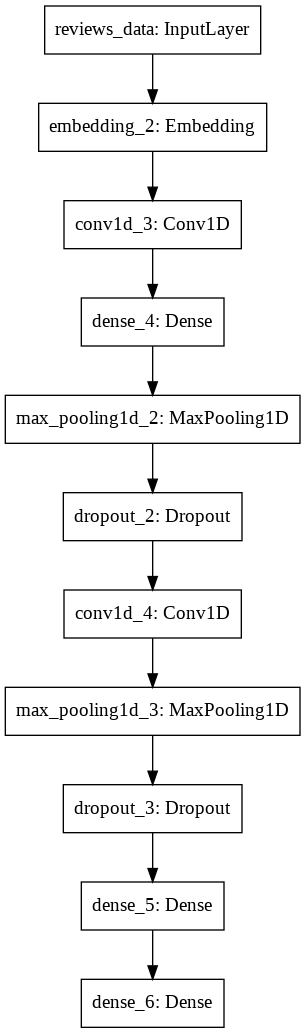

In [ ]:
from keras.utils import plot_model
plot_model(cnn_model, to_file='CNN_8.png')

In [ ]:
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    #Yelp
    input_userDATA = Input(shape = [17], name = 'user_data') 
    input_itemDATA = Input(shape = [49], name = 'item_data')
    ##CNN  
    input_reviews = Input(shape = (MAX_SEQUENCE_LENGTH,), name = 'reviews_data' )
    #GMF part
    user_latent_factors_GMF = 8
    item_latent_factors_GMF = 8

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])

    #HybMLP part
    user_latent_factors_hMLP = 8
    item_latent_factors_hMLP = 8

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)

    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(2,0,-1):
        layer = Dense(32*(2**(l-1)), activation='relu', name= 'layer%d' %(2-l+1))(layer)


    #CNN part**********************************
    
    reviews_emb = Embedding(len(word_index) + 1,
                                EMBEDDING_DIM,
                                weights=[embedding_matrix],
                                input_length=MAX_SEQUENCE_LENGTH,
                                trainable=False) (input_reviews)

    
    cnn_model = Conv1D(32,3,activation="relu") (reviews_emb)
    cnn_model = Dense(1,activation='sigmoid') (cnn_model)
   
    cnn_model = MaxPooling1D(2,2) (cnn_model)
    cnn_model = Dropout(0.2) (cnn_model)
    
    cnn_model =Conv1D(32,3,activation="relu") (cnn_model)
    cnn_model = MaxPooling1D(2,2)(cnn_model)
    cnn_model = Dropout(0.5) (cnn_model)

    feature_Vectors =  Flatten() (cnn_model)

    cnn_model = Dense(12,kernel_regularizer=tf.keras.regularizers.l2(0.01),activation='relu') (feature_Vectors)
    output_cnn = Dense(1,activation='sigmoid') (cnn_model)
    #cnn_model = Model(inputs=input_reviews,outputs= output)
   
    #NeuHybMF part
    concat_NeuhMF = concatenate([mul_layer,layer])
    
    model_NHF = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], concat_NeuhMF)
    
    concat_NeuhCNN_MF=concatenate([model_NHF.output,output_cnn])

    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhCNN_MF)

    model=Model([[input_userID, input_userDATA, input_itemID, input_itemDATA],input_reviews], out)
 
    
    
    

In [ ]:
model.summary()

Model: "model_29"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
reviews_data (InputLayer)       [(None, 3738)]       0                                            
__________________________________________________________________________________________________
embedding_18 (Embedding)        (None, 3738, 300)    22419600    reviews_data[0][0]               
__________________________________________________________________________________________________
conv1d_35 (Conv1D)              (None, 3736, 32)     28832       embedding_18[0][0]               
__________________________________________________________________________________________________
dense_52 (Dense)                (None, 3736, 1)      33          conv1d_35[0][0]                  
___________________________________________________________________________________________

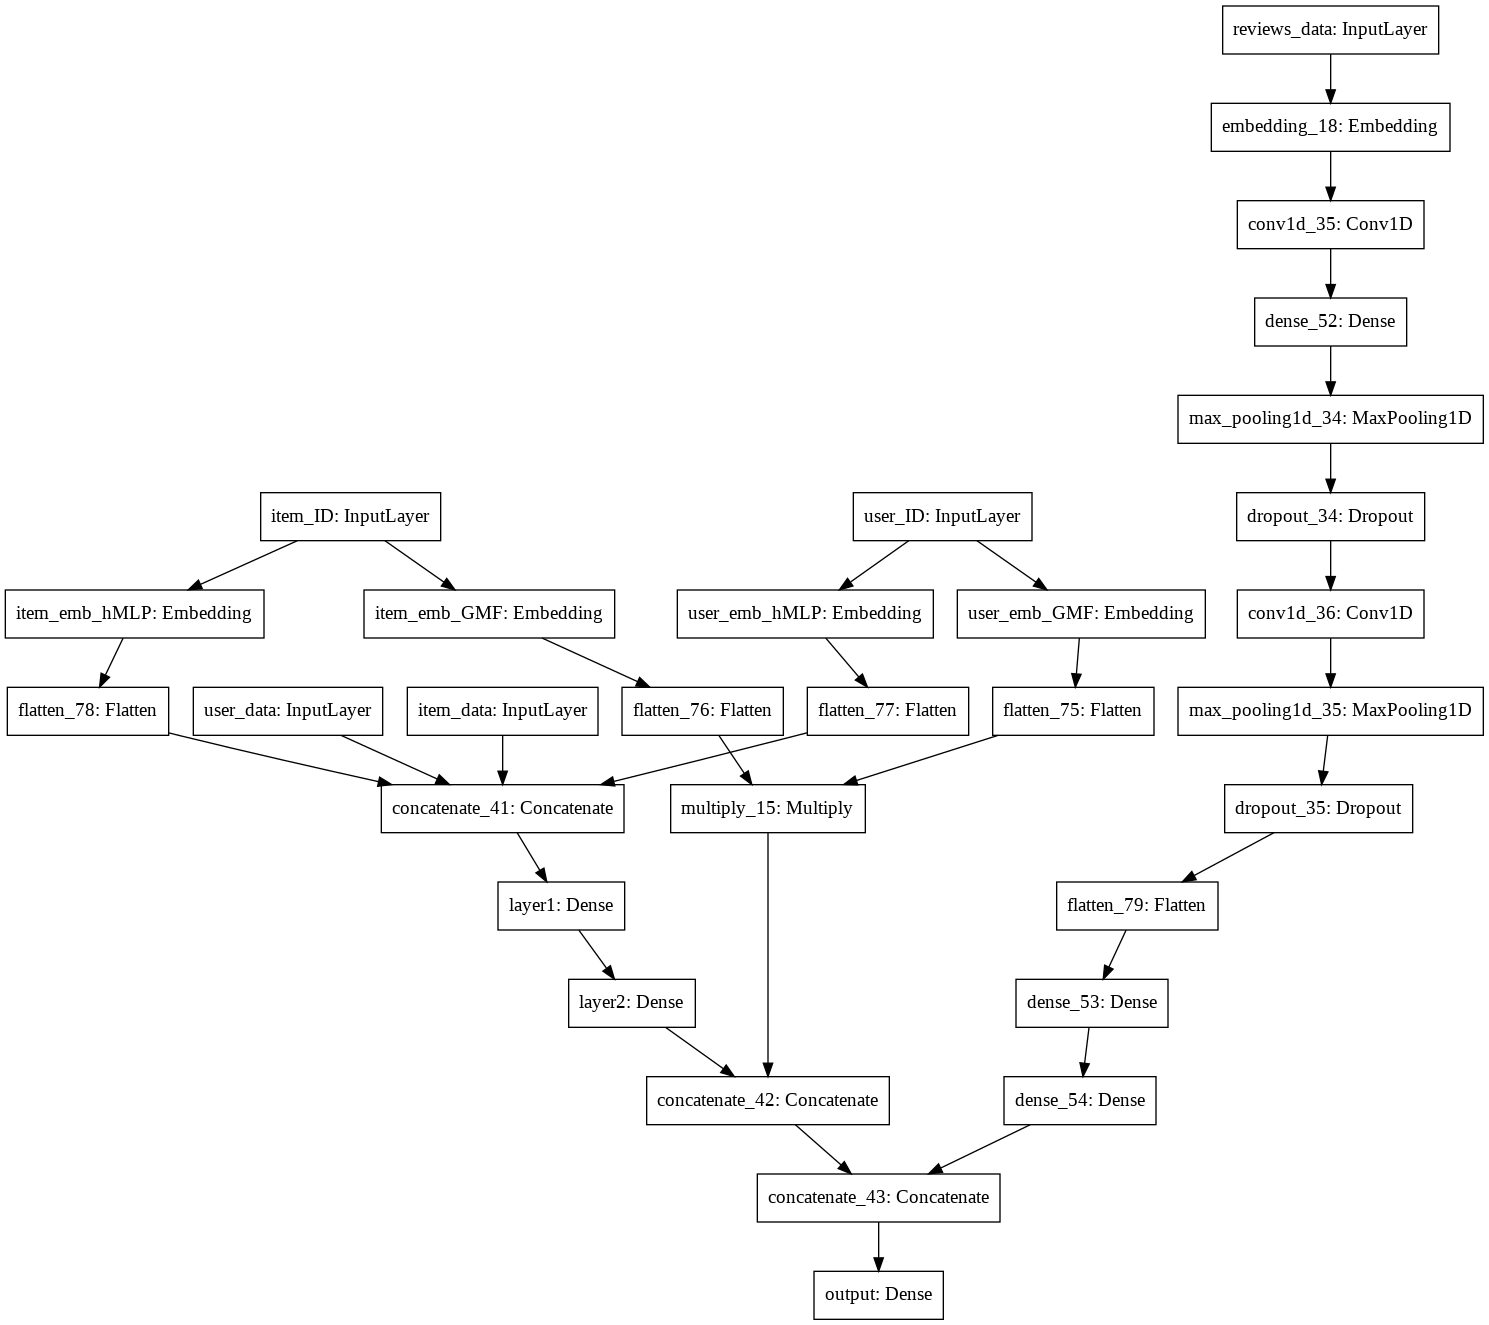

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='Ourmodel.png')

In [ ]:
  #NeuHybMF part
    concat_NeuhMF = concatenate([mul_layer,layer])
    
    model_NHF = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], concat_NeuhMF)
    
    concat_NeuhCNN_MF=concatenate([model_NHF.output,output_cnn])

    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhCNN_MF)

    model=Model([[input_userID, input_userDATA, input_itemID, input_itemDATA],input_reviews], out)
 
    
    

# **PLOT (Data visualization)**
- selon le nombre d'embeddings 

In [ ]:
import pickle 
import pandas as pn
import matplotlib.pyplot as plt
import numpy as np

def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)


def load_MLP_HRs(num_l, embd_size, pred_fact, num_neg) :
    path = '/content/drive/MyDrive/Train and Test DataSets/NEG '+str(num_neg)+'/tests/MLP '+ str(num_l) +' EMB '+ str(embd_size) +' PF '+ str(pred_fact) +'  ColMLP HRs.pkl'
    list = load_obj(path)
    return list


def load_MLP_NDCGs(num_l, embd_size, pred_fact, num_neg) :
    path = '/content/drive/MyDrive/Train and Test DataSets/NEG '+str(num_neg)+'/tests/MLP '+ str(num_l) +' EMB '+ str(embd_size) +' PF '+ str(pred_fact) +'  ColMLP NDCGs.pkl'
    list = load_obj(path)
    return list

def load_HybMLP_HRs(num_l, embd_size, pred_fact, num_neg) :
    if(num_l!=0):
        path = '/content/drive/MyDrive/Train and Test DataSets/NEG '+str(num_neg)+'/tests/MLP '+ str(num_l) +' EMB '+ str(embd_size) +' PF '+ str(pred_fact) +'  hMLP HRs.pkl'
    else:
        path = '/content/drive/MyDrive/Train and Test DataSets/NEG '+str(num_neg)+'/tests/MLP '+ str(num_l) +' EMB '+ str(embd_size) +'  hMLP HRs.pkl'
    
    list = load_obj(path)
    return list


def load_HybMLP_NDCGs(num_l, embd_size, pred_fact, num_neg) :
    if(num_l!=0):
        path = '/content/drive/MyDrive/Train and Test DataSets/NEG '+str(num_neg)+'/tests/MLP '+ str(num_l) +' EMB '+ str(embd_size) +' PF '+ str(pred_fact) +'  hMLP NDCGs.pkl'
    else:
        path = '/content/drive/MyDrive/Train and Test DataSets/NEG '+str(num_neg)+'/tests/MLP '+ str(num_l) +' EMB '+ str(embd_size) +'  hMLP NDCGs.pkl'
    
    list = load_obj(path)
    return list

def load_GMF_HRs(embd_size, num_neg) :
    path = '/content/drive/MyDrive/Train and Test DataSets/NEG '+str(num_neg)+'/tests/EMB '+ str(embd_size) +'  GMF HRs.pkl'
    list = load_obj(path)
    return list

def load_GMF_NDCGs(embd_size, num_neg) :
    path = '/content/drive/MyDrive/Train and Test DataSets/NEG '+str(num_neg)+'/tests/EMB '+ str(embd_size) +'  GMF NDCGs.pkl'
    list = load_obj(path)
    return list

def load_NHF_HRs(num_l, embd_size, pred_fact,num_neg) :
    path_pre = '/content/drive/MyDrive/Train and Test DataSets/NEG '+str(num_neg)+'/tests/MLP '+ str(num_l) +' EMB '+ str(embd_size) +' PF '+ str(pred_fact) +'  pretrained NHF HRs.pkl'
    list_pre = load_obj(path_pre)
    return list_pre

def load_NHF_NDCGs(num_l, embd_size, pred_fact,num_neg) :
    path_pre = '/content/drive/MyDrive/Train and Test DataSets/NEG '+str(num_neg)+'/tests/MLP '+ str(num_l) +' EMB '+ str(embd_size) +' PF '+ str(pred_fact) +'  pretrained NHF NDCGs.pkl'
    list_pre = load_obj(path_pre)
    return list_pre

def load_NCF_HRs(num_l, embd_size, pred_fact,num_neg) :
    path_pre = '/content/drive/MyDrive/Train and Test DataSets/NEG '+str(num_neg)+'/tests/MLP '+ str(num_l) +' EMB '+ str(embd_size) +' PF '+ str(pred_fact) +'  pretrained NCF HRs.pkl'
    list_pre = load_obj(path_pre)
    return list_pre

def load_NCF_NDCGs(num_l, embd_size, pred_fact,num_neg) :
    path_pre = '/content/drive/MyDrive/Train and Test DataSets/NEG '+str(num_neg)+'/tests/MLP '+ str(num_l) +' EMB '+ str(embd_size) +' PF '+ str(pred_fact) +'  pretrained NCF NDCGs.pkl'
    list_pre = load_obj(path_pre)
    return list_pre

def plot_data(list1,l) :
    x, y = zip(*(list1.items()))
    plt.plot(x,y,linestyles[l],linestyle = 'dashed')

    """
linestyles = ['bo','rd','g--','ks','y^']
l=0

num_negs= [1]    
num_layers = [0gt,1,2,3,4,5]  
emb_sizes = [64]
pred_facts = [16]
legends = []
dict1={}
dict2={}
dict3={}
dict4={}
dict5={}
for num_neg in num_negs :   
    for emb in emb_sizes :
        #plot GMF
        
        list3 = load_GMF_NDCGs(emb,num_neg)
        maximum3 = max(list3, key=list3.get)
        dict3[str(num_neg)]=list3[maximum3]
        
        for pf in pred_facts:
            #dict1={}
            for num_layer in num_layers:
                #plot HybMLP
                list1 = load_MLP_HRs(num_layer, emb, pf,num_neg)

                maximum1 = max(list1, key=list1.get)
                dict1[str(num_layer)]=list1[maximum1]

                list2 = load_HybMLP_HRs(num_layer, emb, pf,num_neg)
                
                maximum2 = max(list2, key=list2.get)
                dict2[str(num_layer)]=list2[maximum2]
                #plot NHF
                '''
                list4 = load_NHF_NDCGs(2, 8, 32,num_neg)
                maximum4 = max(list4, key=list4.get)
                dict4[str(num_neg)]=list4[maximum4]
                
                list5 = load_NCF_NDCGs(5, 128, 64,num_neg)
                maximum5 = max(list5, key=list5.get)
                dict5[str(num_neg)]=list5[maximum5]
                '''
             
plot_data(dict1,l)
l=l+1
plot_data(dict2,l)
l=l+1
'''
plot_data(dict3,l)
l=l+1
plot_data(dict4,l)
l=l+1
plot_data(dict5,l)

'''
legends = ['MLP','HybMLP']

print(legends[0],dict1)
print(legends[1],dict2)
'''



print(legends[2],dict3)
print(legends[3],dict4)
print(legends[4],dict5)
'''
plt.ylabel('HR@10')
plt.xlabel('Number of Layers')    
plt.legend(legends, loc='lower right')
plt.show()
"""

In [ ]:
linestyles = ['bo','rd','g--','ks','y^']
l=0

num_negs= [1]    
num_layers = [0,1,2,3,4,5]  
emb_sizes = [64]
pred_facts = [16]
legends = []
dict1={}
dict2={}
dict3={}
dict4={}
dict5={}

In [ ]:
list3 = load_GMF_NDCGs(8,1)
maximum3 = max(list3, key=list3.get)
dict3[str(num_neg)]=list3[maximum3]

In [ ]:
list2 = load_HybMLP_HRs(2, 8, 32,1)              
maximum2 = max(list2, key=list2.get)
dict2[str(2)]=list2[maximum2]

In [ ]:
plot_data(dict2,2)


plot_data(dict3,2)


In [ ]:
legends = ['MLP','HybMLP']
print(legends[1],dict2)
#print(legends[2],dict3)

plt.ylabel('HR@10')
plt.xlabel('Number of Layers')    
plt.legend(legends, loc='lower right')
plt.show()

# Top K recommendations (HR@K, NDCG@K)

In [ ]:
import pandas as pn
import numpy as np
import math
from keras.utils.vis_utils import model_to_dot
from keras.layers.core import Flatten
from keras.layers import Embedding, Dropout, Multiply, Dense, Input
from keras.models import Model
from keras.layers.merge import concatenate
from keras import backend as K
from keras.models import load_model
from time import time
import matplotlib.pyplot as plt
import pickle


num_users = 5436
num_items = 4733
def plot_data(list1,l) :
    styles = ['bo','rd','g--','ks','y^']
    x, y = zip(*(list1.items()))
    plt.plot(x,y,styles[l], linestyle='dashed')
    
def save_obj(obj,path):
    with open(path+'.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(path):
    with open(path, 'rb') as f:
        return pickle.load(f)
    
    
def load_test(num_neg):
    testset = pn.read_csv('/content/drive/MyDrive/Train and Test DataSets/NEG %d/Test.csv'%(num_neg), sep='|')
    
    
    return testset

def evaluate_model(model, model_name, test, k):
    
    #Yelp
    test_userID = test['user_id']
    test_userDATA = test[['fans','average_stars','friends','vote_funny','useful','vote_cool','hot','more',
    'profile','cute','list','note','plain', 'cool','funny','writer','photos']] 

    test_itemID = test['item_id']
    test_itemDATA = test.iloc[:,-50:]

    if(model_name in ['GMF','NCF','MLP']):
        predictions = model.predict([test_userID, test_itemID], verbose=2)
    else:
        predictions = model.predict([test_userID, test_userDATA, test_itemID, test_itemDATA], verbose=2)
        
    predictions = pn.DataFrame(data=predictions,columns=['predicted'])
    predictions = pn.concat([test,predictions], axis=1)
    predictions = predictions.sort_values(by=['predicted'], ascending=False)
    
    users=test.user_id.unique()
    
    hrs, ndcgs = 0,0
    for u in users:
        p= predictions[predictions['user_id']==u].loc[:,'rating'].head(k)
        hr, ndcg = evaluate_by_user(p)
        hrs = hrs + hr
        ndcgs = ndcgs + ndcg
        
    mean_hr = hrs/len(users)
    mean_ndcg = ndcgs/len(users)
        
    return mean_hr, mean_ndcg

def evaluate_by_user(test):
    hr, ndcg = 0, 0
    i=1
    for rating in test:
        if rating == 1 :
            hr = 1
            ndcg = math.log(2)/math.log(i+1)
            break 
        i=i+1    
    return hr, ndcg

#create model 
def build_NHF_model(emb_size_hmlp, emb_size_gmf, predictive_factors, num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    #Yelp
    input_userDATA = Input(shape = [3], name = 'user_data') 
    input_itemDATA = Input(shape = [18], name = 'item_data')
    #GMF part
    user_latent_factors_GMF = emb_size_gmf
    item_latent_factors_GMF = emb_size_gmf

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])

    #HybMLP part
    user_latent_factors_hMLP = emb_size_hmlp
    item_latent_factors_hMLP = emb_size_hmlp

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)

    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
    
    #NeuHybMF part
    concat_NeuhMF = concatenate([mul_layer,layer])
    
    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhMF)

    model = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], out)
    
    return model

#create GMF model
def build_GMF_model(emb_size):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    user_latent_factors_GMF = emb_size
    item_latent_factors_GMF = emb_size

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])
    
    out = Dense(1, activation='sigmoid', name='output')(mul_layer)

    GMF_model = Model([input_userID, input_itemID], out)

    return GMF_model

#create HybMLP model
def build_hMLP_model(emb_size, predictive_factors, num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    input_userDATA = Input(shape = [17], name = 'user_data') 
    input_itemDATA = Input(shape = [50], name = 'item_data')
    
    user_latent_factors_hMLP = emb_size
    item_latent_factors_hMLP = emb_size

    user_emb_hMLP = Embedding(num_users, user_latent_factors_hMLP, name= 'user_emb_hMLP')(input_userID)
    item_emb_hMLP = Embedding(num_items, item_latent_factors_hMLP, name= 'item_emb_hMLP')(input_itemID)

    flat_u_hMLP = Flatten()(user_emb_hMLP)
    flat_i_hMLP = Flatten()(item_emb_hMLP)
    
    concat_hMLP = concatenate([flat_u_hMLP, flat_i_hMLP, input_userDATA, input_itemDATA])
    layer = concat_hMLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
        
    out = Dense(1, activation='sigmoid', name='output')(layer)

    hMLP_model = Model([input_userID, input_userDATA, input_itemID, input_itemDATA], out)

    return hMLP_model

def build_NCF_model(emb_size_mlp, emb_size_gmf, predictive_factors, num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')

    #GMF part
    user_latent_factors_GMF = emb_size_gmf
    item_latent_factors_GMF = emb_size_gmf

    user_emb_GMF = Embedding(num_users, user_latent_factors_GMF, name = 'user_emb_GMF')(input_userID)
    item_emb_GMF = Embedding(num_items, item_latent_factors_GMF, name = 'item_emb_GMF')(input_itemID)

    flat_u_GMF = Flatten()(user_emb_GMF)
    flat_i_GMF = Flatten()(item_emb_GMF)

    mul_layer = Multiply()([flat_u_GMF, flat_i_GMF])

    #MLP part
    user_latent_factors_MLP = emb_size_mlp
    item_latent_factors_MLP = emb_size_mlp

    user_emb_MLP = Embedding(num_users, user_latent_factors_MLP, name= 'user_emb_MLP')(input_userID)
    item_emb_MLP = Embedding(num_items, item_latent_factors_MLP, name= 'item_emb_MLP')(input_itemID)

    flat_u_MLP = Flatten()(user_emb_MLP)
    flat_i_MLP = Flatten()(item_emb_MLP)

    concat_MLP = concatenate([flat_u_MLP, flat_i_MLP])
    layer = concat_MLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
    
    #NeuMF part
    concat_NeuhMF = concatenate([mul_layer,layer])
    
    out = Dense(1, activation='sigmoid', name='output')(concat_NeuhMF)

    model = Model([input_userID, input_itemID], out)
    
    return model


def build_MLP_model(emb_size,predictive_factors,num_layers):
    input_userID = Input(shape = [1], name = 'user_ID')
    input_itemID = Input(shape = [1], name = 'item_ID')
    
    user_latent_factors_MLP = emb_size
    item_latent_factors_MLP = emb_size

    user_emb_MLP = Embedding(num_users, user_latent_factors_MLP, name= 'user_emb_MLP')(input_userID)
    item_emb_MLP = Embedding(num_items, item_latent_factors_MLP, name= 'item_emb_MLP')(input_itemID)

    flat_u_MLP = Flatten()(user_emb_MLP)
    flat_i_MLP = Flatten()(item_emb_MLP)
    
    concat_MLP = concatenate([flat_u_MLP, flat_i_MLP])
    layer = concat_MLP
    for l in range(num_layers,0,-1):
        layer = Dense(predictive_factors*(2**(l-1)), activation='relu', name= 'layer%d' %(num_layers-l+1))(layer)
        
    out = Dense(1, activation='sigmoid', name='output')(layer)

    MLP_model = Model([input_userID, input_itemID], out)

    return MLP_model

    
def load_pretrained_model(model, model_name, gmf_model, hmlp_model, num_layers):
    # MF embeddings
    user_emb_GMF = gmf_model.get_layer('user_emb_GMF').get_weights()
    item_emb_GMF = gmf_model.get_layer('item_emb_GMF').get_weights()
    model.get_layer('user_emb_GMF').set_weights(user_emb_GMF)
    model.get_layer('item_emb_GMF').set_weights(item_emb_GMF)
    if(model_name=='NHF'):
        # HybMLP embeddings
        user_emb_MLP = hmlp_model.get_layer('user_emb_hMLP').get_weights()
        item_emb_MLP = hmlp_model.get_layer('item_emb_hMLP').get_weights()
        model.get_layer('user_emb_hMLP').set_weights(user_emb_MLP)
        model.get_layer('item_emb_hMLP').set_weights(item_emb_MLP)
    elif(model_name=='NCF'):
        # MLP embeddings
        user_emb_MLP = hmlp_model.get_layer('user_emb_MLP').get_weights()
        item_emb_MLP = hmlp_model.get_layer('item_emb_MLP').get_weights()
        model.get_layer('user_emb_MLP').set_weights(user_emb_MLP)
        model.get_layer('item_emb_MLP').set_weights(item_emb_MLP)
    # HybMLP/MLP layers
    for i in range(num_layers):
        mlp_layer_weights = hmlp_model.get_layer('layer%d' %(i+1)).get_weights()
        model.get_layer('layer%d' %(i+1)).set_weights(mlp_layer_weights)
        
    # Prediction weights
    gmf_prediction = gmf_model.get_layer('output').get_weights()
    mlp_prediction = hmlp_model.get_layer('output').get_weights()
    new_weights = np.concatenate((gmf_prediction[0], mlp_prediction[0]), axis=0)
    new_b = gmf_prediction[1] + mlp_prediction[1]
    model.get_layer('output').set_weights([0.5*new_weights, 0.5*new_b])    
    return model


path = 'gdrive/My Drive/pfe_tests/NEG 3/tests/'
metrique = 'NDCG'
'''
testset = load_test(5)
GMF = build_GMF_model(128)
GMF.compile(optimizer = 'adam', loss = 'binary_crossentropy')
GMF.load_weights(path+'EMB 128 GMF.h5', by_name=False)

MLP = build_MLP_model(128,64,5)
MLP.compile(optimizer = 'adam', loss = 'binary_crossentropy')
MLP.load_weights(path+'MLP 5 EMB 128 PF 64 ColMLP.h5', by_name=False)

HybMLP = build_hMLP_model(8,32,5)
HybMLP.compile(optimizer = 'adam', loss = 'binary_crossentropy')
HybMLP.load_weights(path+'MLP 5 EMB 8 PF 32 MLP.h5', by_name=False)

NCF = build_NCF_model(128,128,64,5)
NCF.compile(optimizer = 'sgd', loss = 'binary_crossentropy')
NCF = load_pretrained_model(NCF,'NCF',GMF,MLP,5)

NHF = build_NHF_model(8,128,32,5)
NHF.compile(optimizer = 'sgd', loss = 'binary_crossentropy')
NHF = load_pretrained_model(NHF,'NHF',GMF,HybMLP,5)



GMF_HR={}
MLP_HR={}
HybMLP_HR={}
NCF_HR={}
NHF_HR={}

GMF_NDCG={}
MLP_NDCG={}
HybMLP_NDCG={}
NCF_NDCG={}
NHF_NDCG={}

for k in range(1,11):
    print(metrique+'@%d'%k)
    GMF_HR[k], GMF_NDCG[k] = evaluate_model(GMF,'GMF',testset,k)
    MLP_HR[k], MLP_NDCG[k] = evaluate_model(MLP,'MLP',testset,k)
    HybMLP_HR[k], HybMLP_NDCG[k] = evaluate_model(HybMLP,'HybMLP',testset,k)
    NCF_HR[k], NCF_NDCG[k] = evaluate_model(NCF,'NCF',testset,k)
    NHF_HR[k], NHF_NDCG[k] = evaluate_model(NHF,'NHF',testset,k)
    


save_obj(GMF_HR,path+'GMF HR@K')
save_obj(MLP_HR,path+'ColMLP HR@K')
save_obj(HybMLP_HR,path+'MLP HR@K')
save_obj(NCF_HR,path+'NCF HR@K')
save_obj(NHF_HR,path+'NHF HR@K')

save_obj(GMF_NDCG,path+'GMF NDCG@K')
save_obj(MLP_NDCG,path+'ColMLP NDCG@K')
save_obj(HybMLP_NDCG,path+'MLP NDCG@K')
save_obj(NCF_NDCG,path+'NCF NDCG@K')
save_obj(NHF_NDCG,path+'NHF NDCG@K')

'''
list1 = load_obj(path+'ColMLP '+metrique+'@K.pkl')
list2 = load_obj(path+'MLP '+metrique+'@K.pkl')
list3 = load_obj(path+'GMF '+metrique+'@K.pkl')
list4 = load_obj(path+'NHF '+metrique+'@K.pkl')
list5 = load_obj(path+'NCF '+metrique+'@K.pkl')

l=0
plot_data(list1,l)
l=l+1
plot_data(list2,l)
l=l+1
plot_data(list3,l)
l=l+1
plot_data(list4,l)
l=l+1
plot_data(list5,l)

legend1 = 'MLP'
legend2 = 'HybMLP'
legend3 = 'GMF'
legend4 = 'NHybF'
legend5 = 'NCF'

print(metrique+'\n')
print(legend1,list1)
print(legend2,list2)
print(legend3,list3)
print(legend4,list4)
print(legend5,list5)

legends = [legend1,legend2,legend3,legend4,legend5]

plt.ylabel(metrique+'@K')
plt.xlabel('K')  
xmin = 1
plt.legend(legends, loc='lower right')
ymax = max(list1[10],list2[10],list3[10],list4[10],list5[10])
ymin = min(list1[xmin],list2[xmin],list3[xmin],list4[xmin],list5[xmin])

plt.axis([xmin, 10, ymin,ymax])
plt.show()